In [1]:
import time
import itertools
import numpy as np
import matplotlib.pyplot as plt

from swim import LJ, simple_md3d

#### Initialize system

In [2]:
m = 4
spacing = 4
L = m * spacing
x_ref = np.linspace(-L/2, L/2, m, endpoint=False) + spacing/2
position = np.array(list(itertools.product(x_ref, repeat=3)))

num_particles = 64
init_x3d = position[:num_particles]
init_v3d = np.random.rand(num_particles,3)[:num_particles]

kT = 1.0

#### Set up Lennard-Jones potential

In [3]:
lj = LJ()
lj.param = {'epsilon':2.3, 
            'sigma':1.0, 
            'r_cut': 3.0}

#### Run MD

In [4]:
start = time.time()

md = simple_md3d(seed=2392)
md.set_param(dt=0.01,
             kT=kT, 
             damping=10.)
md.set_init_config(init_x3d=init_x3d,
                   init_v3d=init_v3d,
                   num_particles=num_particles,
                   box=[L, L, L])

# initialize velocity with kT
md.init_v3d = md.v_rescale(init_v3d, kT)

md.pe = lj
md.run(int(1e5))

print(time.time() - start, 's')

24.6046462059021 s


#### Use gsd to store trajectory. The gsd file can be visualized using Ovito.

In [5]:
import gsd.hoomd

def create_snapshot(i, x):
    global num_particles

    N_particles = md.num_particles
    box = md.box
    
    snapshot = gsd.hoomd.Frame()
    snapshot.particles.types = ['A']
    snapshot.particles.N = N_particles
    snapshot.particles.typeid = [0] * N_particles
    snapshot.particles.position = x
    
    d = 1.0
    snapshot.particles.diameter = [d] * N_particles
    snapshot.configuration.box = [box[0], box[1], box[2], 0, 0, 0]
    snapshot.configuration.step = i
    
    return snapshot

f = gsd.hoomd.open(name='./md3d_traj.gsd', mode='w')

dump_stride = 1000
for i, x, _ in md.traj[::dump_stride]:
    snapshot = create_snapshot(i, x)
    f.append(snapshot)
    f.flush()

#### Take a look at the trajectory of kinetic and potential energy

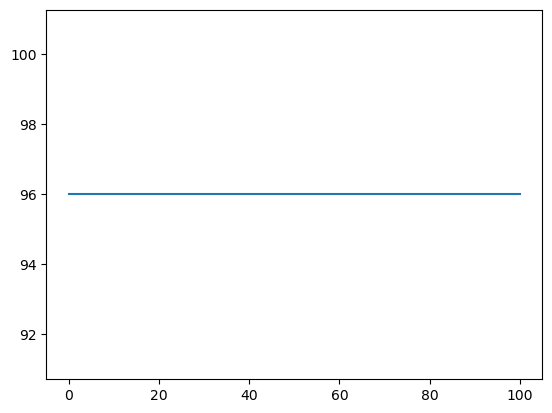

In [6]:
traj_ke = []
for i, x, v in md.traj[::1000]:
    ke = 0.5 * np.sum(v**2)
    traj_ke.append( ke )

plt.plot(traj_ke)

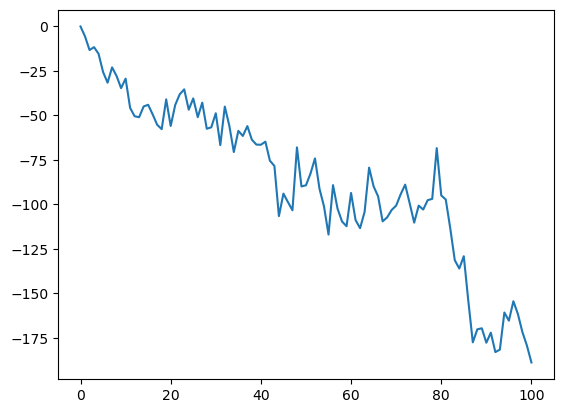

In [7]:
traj_pe = []
for i, x, v in md.traj[::1000]:
    nlist_pe = md.nlist_search(x, rcut=lj.param['r_cut'], full=False)
    pe = md.compute_pe(x, nlist_pe)
    traj_pe.append(pe)

plt.plot(traj_pe)